In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class new_recon(nn.Module):
    def __init__(self):
        super(new_recon, self).__init__()

    def forward(self, output, labels, unconvs, inputs, lamda=1):
        loss = nn.CrossEntropyLoss()(output, labels)
        loss += lamda * nn.MSELoss()(inputs, unconvs)
        return loss


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.unconv1 = nn.ConvTranspose2d(16, 6, 5)
        self.unconv2 = nn.ConvTranspose2d(6, 3, 5)
    
    def forward(self, x):
        # print(x.shape)
        x, indices1 = self.pool(F.relu(self.conv1(x)))
        x, indices2 = self.pool(F.relu(self.conv2(x)))
        # calculating y
        y = torch.flatten(x, 1)
        y = F.relu(self.fc1(y))
        y = F.relu(self.fc2(y))
        y = self.fc3(y)
        # calculating x
        x = self.unconv1(F.relu(self.unpool(x, indices2)))
        x = self.unconv2(F.relu(self.unpool(x, indices1)))
        return y, x


    def reconstruct_layer1(self, x):
        Xs = []
        x = F.relu(self.conv1(x))
        x, indices1 = self.pool(x)
        og_x = x.clone()
        # print(x.shape)
        # print(og_x.shape)
        for i in range(6):
            x = og_x.clone()
            # make zero all but i
            x[0][:i] = 0
            x[0][i+1:] = 0
            
            # calculating x
            x = self.unconv2(F.relu(self.unpool(x, indices1)))
            Xs.append(x[0].detach().clone())
        Xs = torch.stack(Xs)
        # print(Xs.shape)
        return Xs


    def reconstruct_layer2(self, x):
        Xs = []
        x = F.relu(self.conv1(x))
        x, indices1 = self.pool(x)
        x = F.relu(self.conv2(x))
        x, indices2 = self.pool(x)
        og_x = x.clone()
        for i in range(3):
            x = og_x.clone()
            x[0][:i] = 0
            x[0][i+1:] = 0
            # calculating x
            x = self.unconv1(F.relu(self.unpool(x, indices2)))
            x = self.unconv2(F.relu(self.unpool(x, indices1)))
            Xs.append(x[0].detach().clone())
        Xs = torch.stack(Xs)
        return Xs




In [4]:
PATH = './cifar_net.pth'

In [5]:
# loading back the net
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

trainiter = iter(testloader)
train_image, train_label = next(trainiter)
testiter = iter(testloader)
test_image, test_label = next(testiter)



In [7]:
Xs1_train = net.reconstruct_layer1(train_image)
Xs2_train = net.reconstruct_layer2(train_image)
Xs1_test = net.reconstruct_layer1(test_image)
Xs2_test = net.reconstruct_layer2(test_image)

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

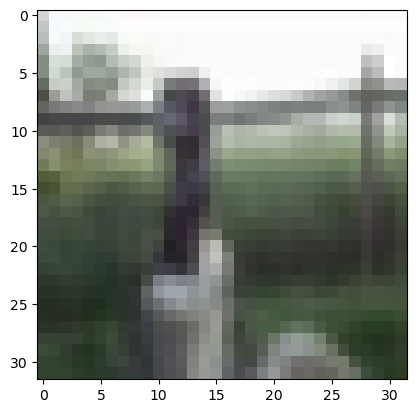

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


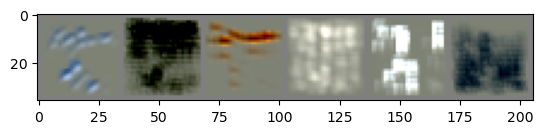

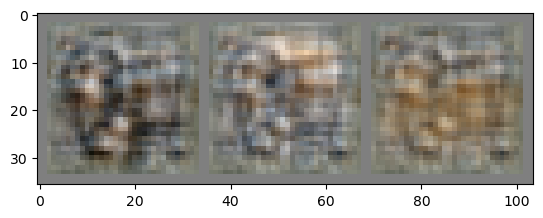

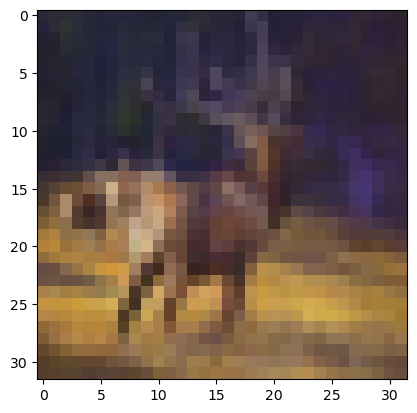

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


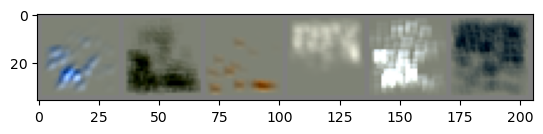

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


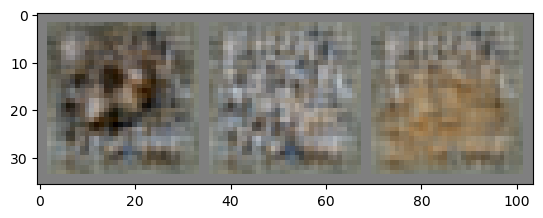

In [9]:
imshow(torchvision.utils.make_grid(train_image))
imshow(torchvision.utils.make_grid(Xs1_train))
imshow(torchvision.utils.make_grid(Xs2_train))
imshow(torchvision.utils.make_grid(test_image))
imshow(torchvision.utils.make_grid(Xs1_test))
imshow(torchvision.utils.make_grid(Xs2_test))
